# Problem Definition
### Assume having a bank branch with 15 teller windows offering different services  to customers. Each window teller serves certain number of customers (10s, 100s or 1000s) each day. The bank is trying to predict the customer traffic for the next month, on a daily basis, based on the provided data history.


In [1]:
# imports
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from notebook_utils import *

In [2]:
# loading the dataset
data = pd.read_csv('bank_traffic_data.csv')

## The following is very basic data exploration (data size, missing values, columns data types)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10013 non-null  object
 1   count      10013 non-null  int64 
 2   window     10013 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.8+ KB


In [4]:
data.describe()

,count,window
count,10013.000000,10013.000000
mean,261.946669,8.020673
std,453.700521,4.334112
min,0.000000,1.000000
25%,0.000000,4.000000
50%,134.000000,8.000000
75%,211.000000,12.000000
max,4670.000000,15.000000


In [5]:
data.head()

,timestamp,count,window
0,2019-09-26 02:00:00+02:00,764,1
1,2019-09-27 02:00:00+02:00,0,1
2,2019-09-28 02:00:00+02:00,0,1
3,2019-09-29 02:00:00+02:00,1973,1
4,2019-09-30 02:00:00+02:00,1908,1


In [6]:
data.tail()

,timestamp,count,window
10008,2021-07-27 02:00:00+02:00,173,15
10009,2021-07-28 02:00:00+02:00,117,15
10010,2021-07-29 02:00:00+02:00,137,15
10011,2021-07-30 02:00:00+02:00,0,15
10012,2021-07-31 02:00:00+02:00,0,15


In [7]:
# checking timestamp column data type
type(data.iloc[0]['timestamp'])

str

In [8]:
# convert timestamp column's data type to datetime since it appears to be a plain string
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.date
print(type(data.iloc[0]['timestamp']))
data.head()

<class 'datetime.date'>


,timestamp,count,window
0,2019-09-26,764,1
1,2019-09-27,0,1
2,2019-09-28,0,1
3,2019-09-29,1973,1
4,2019-09-30,1908,1


## Explore the relationship between the month of the year within and the "count" registered
### Maybe we would discover some basic trends in the data

In [9]:
# grouping data upon month
month_year_grouped = pd.DataFrame({
    'date': data['timestamp'].apply(lambda x: x.strftime('%Y-%m')),
    'window': data['window'], 
    'count': data['count']
})

month_year_grouped = month_year_grouped.groupby(['date'])['count'].sum().reset_index()
month_year_grouped.head()

,date,count
0,2019-09,12087
1,2019-10,128162
2,2019-11,112411
3,2019-12,159805
4,2020-01,87852


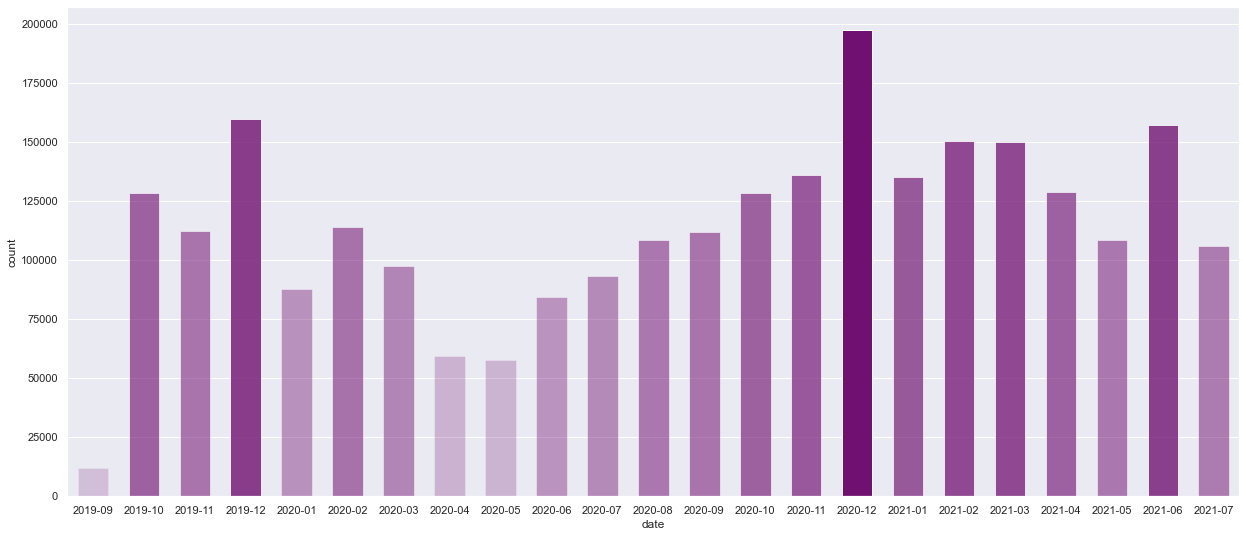

In [10]:
# visualize the month/count relationship 
sns.set(rc={'figure.figsize': (21,9)})
barplot = sns.barplot(x='date', y='count', data=month_year_grouped, color='purple')
for bar, alpha in zip(barplot.containers[0], get_alpha_values(month_year_grouped['count'])):
    bar.set_alpha(alpha)
change_width(barplot, 0.6)

### After the first look on the above graph:
- It appear that some months experience regular higher traffic like December in 2019 and 2020, in general it appears that the month of the year has a strong impact on the resulted count
- We notice a substantial dip in the count of some months, which mostly suggests a reaction to some event in the market (notice march in 2020 and 2021)

## Lets see the relationship between window number and the TOTAL registered count for that window through all given months

In [11]:
# grouping upon window number
window_grouped = pd.DataFrame({
    'window': data['window'], 
    'count': data['count']
})

window_grouped = window_grouped.groupby(['window'])['count'].sum().reset_index()

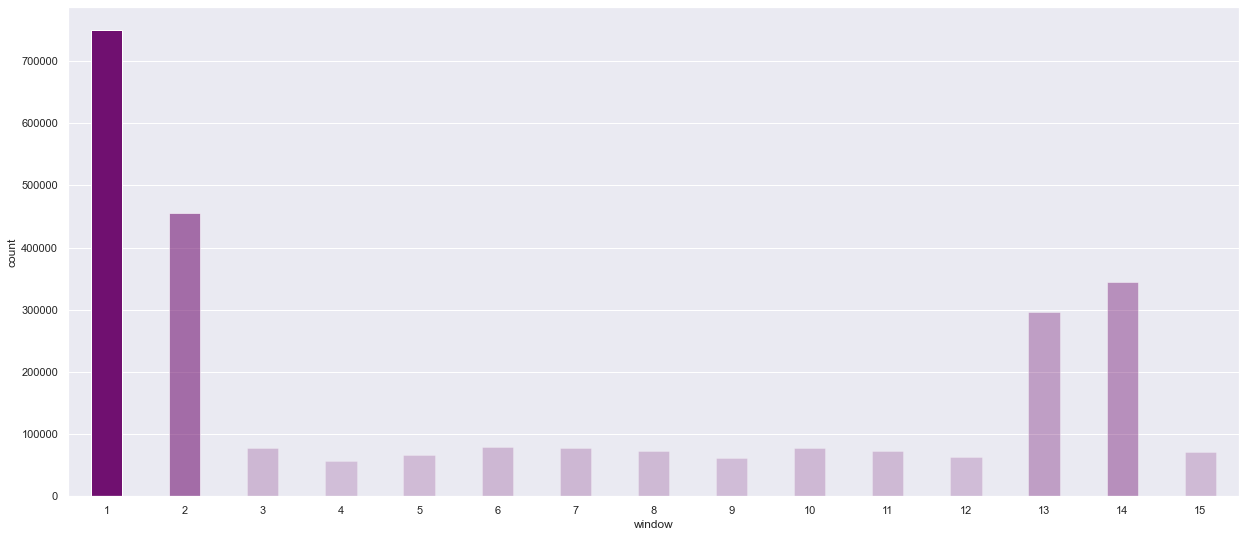

In [12]:
# visualize the month/count relationship 
sns.set(rc={'figure.figsize': (21,9)})
barplot = sns.barplot(x='window', y='count', data=window_grouped, color='purple')
for bar, alpha in zip(barplot.containers[0], get_alpha_values(window_grouped['count'])):
    bar.set_alpha(alpha)
change_width(barplot, 0.4)

### The above graph makes us notice the diffrence in traffic based on window number

## We thought about visualizing windows count along the given months, we think that would give us basic insights about data distribution

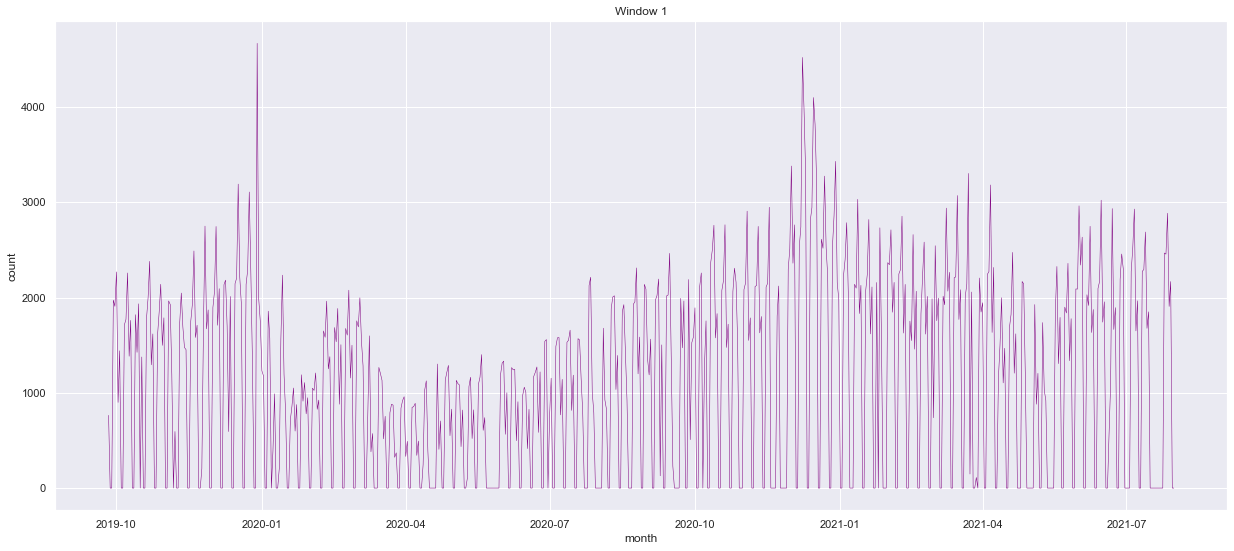

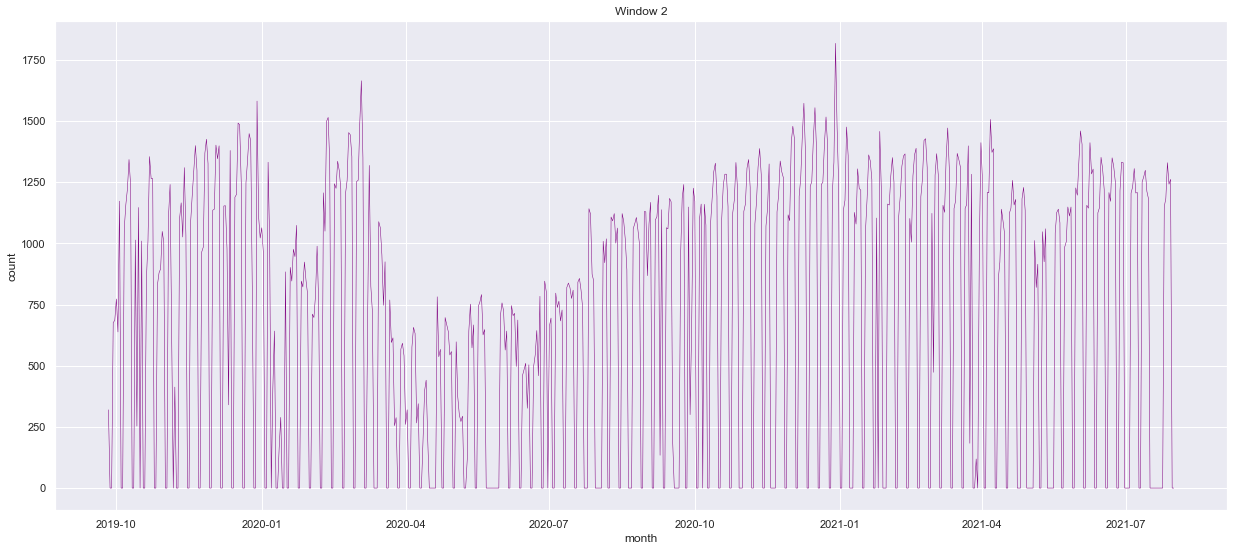

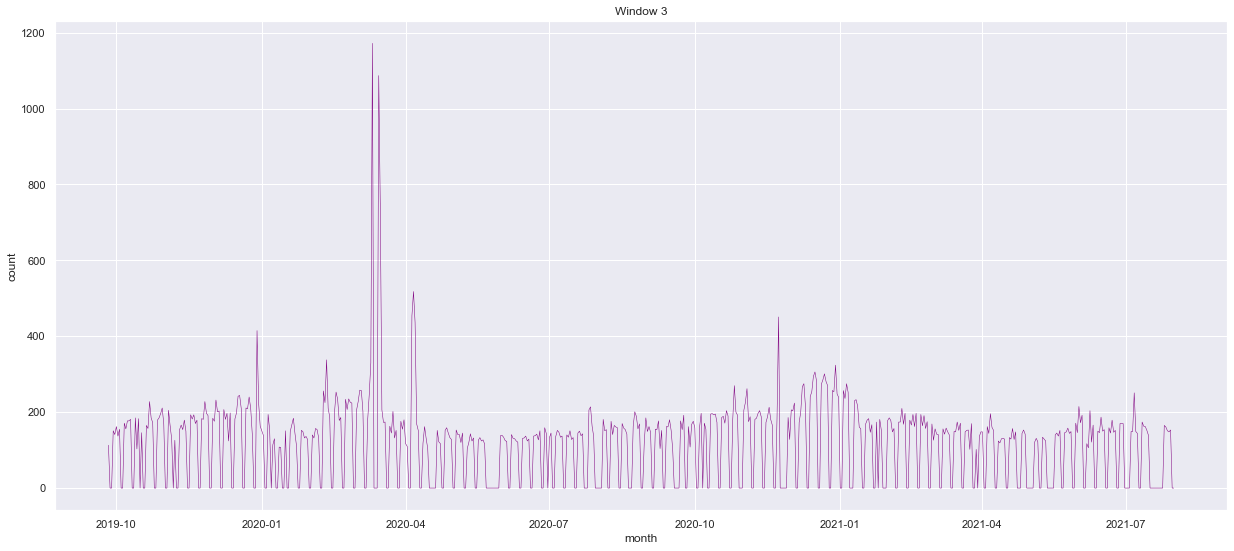

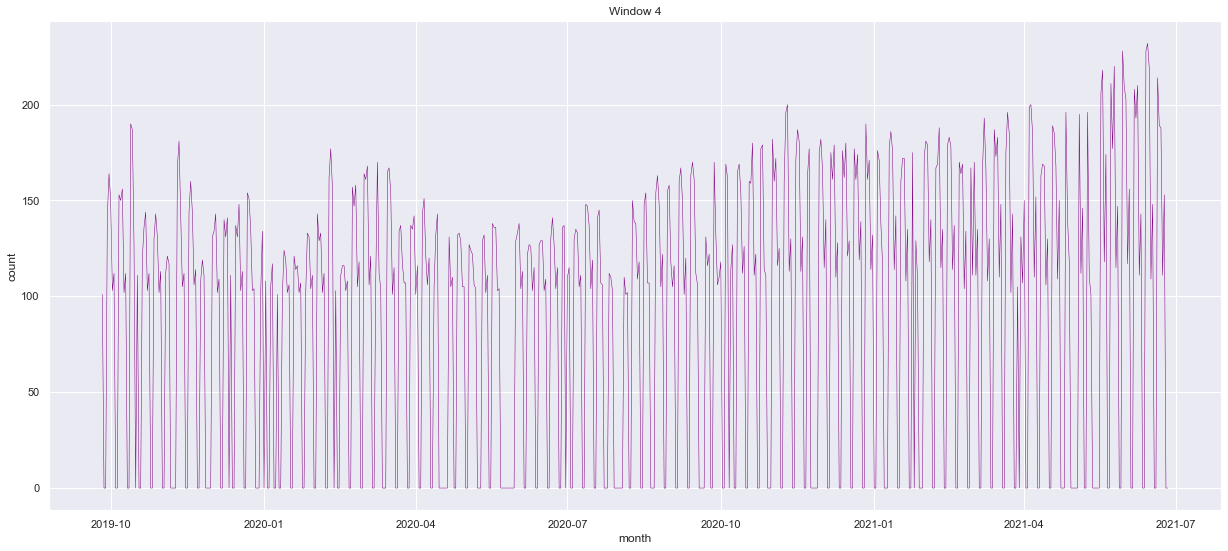

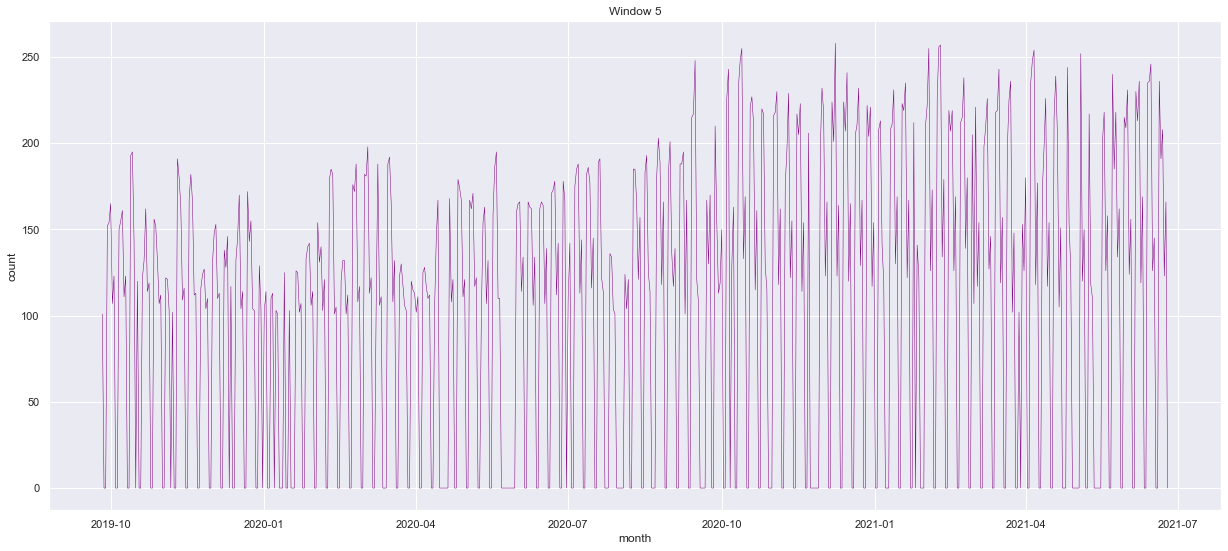

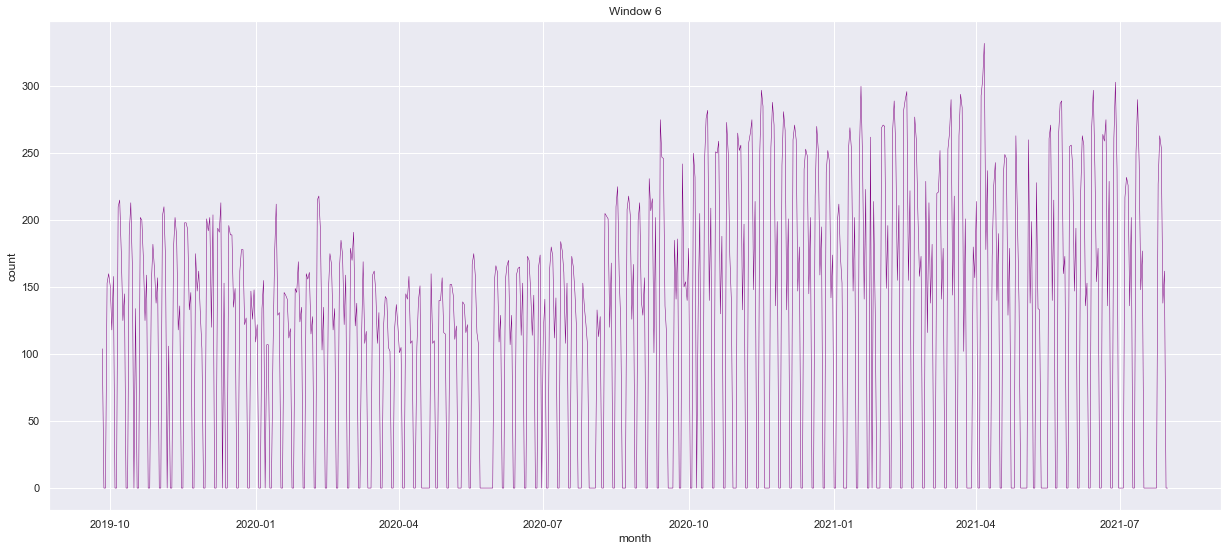

In [13]:
# visulaizing only 7 windows is more than enough
for i in range(1, 7):
    window_data = data[data['window'] == i]
    count = window_data['count'].count()

    sns.set(rc={'figure.figsize': (21,9)})
    ax = sns.lineplot(x=window_data['timestamp'], y=window_data['count'], linewidth=0.5, color='purple')
    ax.set(xlabel='month', ylabel='count', title=f'Window {i}')
    plt.show()

### Examining the above graphs we notice that nearly all the windows experience the dip in the count starting from Jan, 2021 until July, 2021, while some windows don't experience them we think it maybe because of their initial low counts like window 4 as an example

<br>

### We think this dip's root cause is the emerging of COVID-19 in Egypt which would naturally affect banks traffic, The following graph (Daily new COVID-19 cases in Egypt) supports our hypothesis (notice months from Jan 2021 to July 2021)

<p align="center">
<img src="egy-daily-new-cases.PNG">
</p>


# Data preprocessing

In [14]:
%%capture
!pip install holidays

## We decided to add a column to indicate wether this day is a holiday (national holiday/weekend) or a workday, we think this feature ould help a lot since some of the low-traffic windows have counts = 0 in workdays

In [15]:
import holidays
import pandas as pd

In [16]:
# retreiving holidays for years 2019, 2020, 2021
holidays_set = set()
for date in holidays.Egypt(years=[2019, 2020, 2021]).items():
    holidays_set.add(date[0])

holiday = []
for idx, row in data.iterrows():
    if (row['timestamp'] in holidays_set or row['timestamp'].weekday() in [4, 5]) and row['count'] == 0:
        holiday.append(1)
    else:
        holiday.append(0)

# appending a new holiday column in our data
data['holiday'] = pd.Series(holiday).values
data.head()

,timestamp,count,window,holiday
0,2019-09-26,764,1,0
1,2019-09-27,0,1,1
2,2019-09-28,0,1,1
3,2019-09-29,1973,1,0
4,2019-09-30,1908,1,0


## Extracting month, day, year features from the timestamp column

In [17]:
# extract day, month, year info from timestamp column and create new columns containing the extrcated info
data['day'] = data['timestamp'].map(lambda x: x.day)
data['month'] = data['timestamp'].map(lambda x: x.month)
data['year'] = data['timestamp'].map(lambda x: x.year)

# take a look at the data after the previous changes
data.head()

,timestamp,count,window,holiday,day,month,year
0,2019-09-26,764,1,0,26,9,2019
1,2019-09-27,0,1,1,27,9,2019
2,2019-09-28,0,1,1,28,9,2019
3,2019-09-29,1973,1,0,29,9,2019
4,2019-09-30,1908,1,0,30,9,2019


### Based on our analysis we are now sure that covid ahs a huge imact on windows' count

### We decided to a add a very important feature "covid19 confirmed cases in Egypt", we decided to add this column rather than guessing covid-19 waves' time ranges

### We did this by getting the world's corona's registered database and filtering Egypt's data from it, you can find this work in "covid_data_extraction" directory

In [19]:
covid19_df = pd.read_csv('covid_data_extraction/egy_covid_cases.csv')
print(len(covid19_df))
covid19_df.head()

565


,timestamp,confirmed,deaths,recovered,active
0,2/14/2020,1,0,0,1
1,2/15/2020,1,0,0,1
2,2/16/2020,1,0,0,1
3,2/17/2020,1,0,0,1
4,2/18/2020,1,0,0,1


In [20]:
covid19_df.dropna(inplace=True)
covid19_df['timestamp'] = pd.to_datetime(covid19_df['timestamp']).dt.date
print(len(covid19_df))
covid19_df.tail()

565


,timestamp,confirmed,deaths,recovered,active
560,2021-08-27,287393,16706,237385,33302
561,2021-08-28,287644,16714,237817,33113
562,2021-08-29,287899,16721,238249,32929
563,2021-08-30,288162,16727,238580,32855
564,2021-08-31,288441,16736,239343,32362


In [21]:
data['covid19_confirmed_cases'] = 0
covid19_df_timestamp = covid19_df['timestamp'].to_list()
for idx, row in data.iterrows():
    if row['timestamp'] in covid19_df_timestamp:
        data.at[idx, 'covid19_confirmed_cases'] = covid19_df[covid19_df['timestamp'] == row['timestamp']]['confirmed']

data.tail()

,timestamp,count,window,holiday,day,month,year,covid19_confirmed_cases
10008,2021-07-27,173,15,0,27,7,2021,284090
10009,2021-07-28,117,15,0,28,7,2021,284128
10010,2021-07-29,137,15,0,29,7,2021,284170
10011,2021-07-30,0,15,1,30,7,2021,284215
10012,2021-07-31,0,15,1,31,7,2021,284262


In [22]:
data.drop('timestamp', axis=1, inplace=True)

### We used the following two cells to split the given vbanking data to train and test our models, but finally after achieving our last results we decided to train the model with all of our data

In [23]:
test_df = data[(data['month'] == 7) & (data['year'] == 2021)]
print(len(test_df))
test_df.head()

372


,count,window,holiday,day,month,year,covid19_confirmed_cases
644,0,1,0,1,7,2021,281524
645,0,1,1,2,7,2021,281722
646,0,1,1,3,7,2021,281903
647,2276,1,0,4,7,2021,282082
648,2521,1,0,5,7,2021,282257


In [24]:
train_df = data.drop(data[(data['month'] == 7) & (data['year'] == 2021)].index)
print(len(train_df))
train_df.head()

9641


,count,window,holiday,day,month,year,covid19_confirmed_cases
0,764,1,0,26,9,2019,0
1,0,1,1,27,9,2019,0
2,0,1,1,28,9,2019,0
3,1973,1,0,29,9,2019,0
4,1908,1,0,30,9,2019,0


## Model Training

## We used PyCaret to grid search through multiple algorithms

In [30]:
%%capture
!pip install -U pycaret

In [24]:
from pycaret.regression import *

In [32]:
s = setup(data=train_df, test_data=test_df, target='count',  
fold_strategy='timeseries', fold=3, numeric_features=['day', 'month', 'year', 'window'])

best = compare_models(sort='MAE', turbo=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,86.2908,51066.9811,156.7823,0.4889,1.0418,0.2844,0.3267
dt,Decision Tree Regressor,87.0274,50509.6058,156.9798,0.4831,1.0306,0.2979,0.0267
rf,Random Forest Regressor,87.6187,50615.5129,156.8946,0.4835,0.9825,0.2964,0.3267
ada,AdaBoost Regressor,91.0701,50663.2049,160.3385,0.4432,1.1109,0.3196,0.0900
lightgbm,Light Gradient Boosting Machine,94.3960,52409.1936,162.7859,0.4210,1.5953,0.3180,0.0800
gbr,Gradient Boosting Regressor,100.9132,55271.3456,167.8655,0.3796,1.8555,0.3448,0.2167
ransac,Random Sample Consensus,101.9855,53828.8522,169.2224,0.3417,1.9113,0.3270,0.0533
svm,Support Vector Regression,138.7078,60931.5690,197.9730,-0.1501,3.0027,0.3087,1.2100
huber,Huber Regressor,138.9736,61151.8337,198.2437,-0.1517,2.9999,0.3117,0.0200
knn,K Neighbors Regressor,169.3211,101329.7478,278.3431,-5.7723,1.7125,0.9590,0.0300


In [33]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [34]:
prediction_holdout = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,76.7792,54268.2322,232.9554,0.8107,1.5611,0.1931


In [35]:
save_model(best, 'best_MAE_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       float_dtype='float32', id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=['day', 'month',
                                                           'year', 'window'],
                                       target='count', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorica...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
  

In [ ]:
# import joblib
# loaded_model = joblib.load('./best_MAE_model.pkl')

# from sklearn.metrics import mean_absolute_error
# predictions = predict_model(best, data=test_df).Label
# mean_absolute_error(test_count, predictions.Label)

75.84943548387098

## Preparing the real testing dataframe by replicating the training data preparation pipeline

In [36]:
dates_list = []
windows_list = []
holidays_list = []

for i in range(1, 32):
    date = f'2021-08-{i}'
    for window in range(1, 16):
        windows_list.append(window)
        dates_list.append(date)

test_set = pd.DataFrame({
    'window': windows_list,
    'timestamp': dates_list,
    'holiday': 0
})

test_set['timestamp'] = pd.to_datetime(test_set['timestamp']).dt.date

for idx, row in test_set.iterrows():
    if (row['timestamp'] in holidays_set or row['timestamp'].weekday() in [4, 5]):
        holiday.append(1)

test_set['day'] = test_set['timestamp'].map(lambda x: x.day)
test_set['month'] = test_set['timestamp'].map(lambda x: x.month)
test_set['year'] = test_set['timestamp'].map(lambda x: x.year)

test_set['covid19_confirmed_cases'] = 0
#test_set['covid19_active_cases'] = 0
covid19_df_timestamp = covid19_df['timestamp'].to_list()
for idx, row in test_set.iterrows():
    if row['timestamp'] in covid19_df_timestamp:
        #test_set.at[idx, 'covid19_active_cases'] = covid19_df[covid19_df['timestamp'] == row['timestamp']]['active']
        test_set.at[idx, 'covid19_confirmed_cases'] = covid19_df[covid19_df['timestamp'] == row['timestamp']]['confirmed']

test_timestamp = test_set['timestamp']
#test_set.drop('timestamp', axis=1, inplace=True)

test_set.head()

,window,timestamp,holiday,day,month,year,covid19_confirmed_cases
0,1,2021-08-01,0,1,8,2021,284311
1,2,2021-08-01,0,1,8,2021,284311
2,3,2021-08-01,0,1,8,2021,284311
3,4,2021-08-01,0,1,8,2021,284311
4,5,2021-08-01,0,1,8,2021,284311


In [38]:
predicted_submission = pd.DataFrame({
    'window': windows_list,
    'timestamp': test_timestamp,
    'count': predictions
})

predicted_submission.head()

,window,timestamp,count
0,1,2021-08-01,2113.08
1,2,2021-08-01,1263.74
2,3,2021-08-01,164.44
3,4,2021-08-01,168.56
4,5,2021-08-01,194.02


In [39]:
predicted_submission.to_csv('./out_predicted_submission.csv', index=False, header=True)